# 因果デジタルツイン

このノートブックではDirectLiNGAMモデルによる因果デジタルツインを検証する。

In [1]:
import numpy as np
import pandas as pd
from scipy.special import expit

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, precision_score, recall_score

from cdt.metrics import SHD

import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from lingam.utils import make_dot as _make_dot
def make_dot(dag, labels=None):
    return _make_dot(dag, lower_limit=0, labels=labels)

from common import CausalDigitalTwin, generate_test_data, discretize, draw_hist, make_tables, draw_pred_hist

np.random.seed(1)

No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.


## 因果デジタルツインのクラス

## 1. データ生成

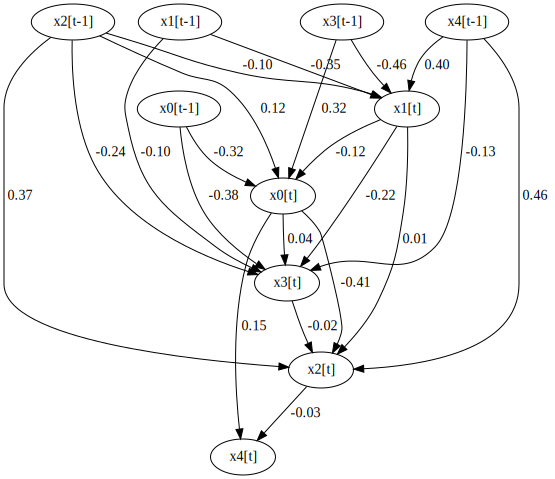

In [2]:
# 元の隣接行列は次と同じ：https://github.com/cdt15/lingam/blob/master/examples/VARLiNGAM.ipynb
causal_graph_true = np.array([
    [
        [0,-0.12,0,0,0],
        [0,0,0,0,0],
        [-0.41,0.01,0,-0.02,0],
        [0.04,-0.22,0,0,0],
        [0.15,0,-0.03,0,0],
    ],
    [
        [-0.32,0,0.12,0.32,0],
        [0,-0.35,-0.1,-0.46,0.4],
        [0,0,0.37,0,0.46],
        [-0.38,-0.1,-0.24,0,-0.13],
        [0,0,0,0,0],
    ]
])
n_features = causal_graph_true.shape[1]
n_lags = len(causal_graph_true) - 1

def to_dag(causal_graph):
    n_features = causal_graph.shape[1]
    concated = np.zeros((n_features * len(causal_graph), n_features * len(causal_graph)))
    concated[:n_features, :] = np.concatenate(causal_graph, axis=1)
    return concated

def draw_graph(causal_graph):
    concated = to_dag(causal_graph)
    n_features = causal_graph.shape[1]
    labels = [f"x{i}[t]" for i in range(n_features)] + [f"x{i}[t-1]" for i in range(n_features)]
    display(make_dot(concated, labels=labels))
    
draw_graph(causal_graph_true)

causal_order = [1, 0, 3, 2, 4]
# XXX: 誤差項の分散の占める割合を調整できないため、すべて1とする。
ratio_list = np.array([1, 1, 1, 1, 0.01])

sink_index = 4

def data_gen_time_series(causal_graph, errors, discrete_index=None):
    # VARについては倍の長さのerrorを与える。最初の方が不安定化もしれないため。出力はlen(errors)の半分になる。
    
    def _discretize(data, e, discrete_index):
        data[discrete_index] = (expit(data[discrete_index] - e[discrete_index]) >= np.random.uniform()).astype(int)
        return data
    
    def _x_t(X, e, B):
        _, n_features, _ = B.shape
        
        # (I - B_0)^-1
        term = np.linalg.pinv(np.eye(n_features) - B[0])

        # Sigma[B_tau @ x(t-tau)] + e(t)
        # Bは横につなげて、Xは縦につなげる
        # Bの2番目以降を横に連結、Xの最新からBの2番目以降との積をとる部分を縦に連結して、行列の積
        term2 = np.hstack(B[1:]) @ np.hstack(X[:, ::-1][:, :len(B) - 1]).reshape(n_features, 1) + e
        
        data = term @ term2
        
        if discrete_index is not None:
            data = _discretize(data, e, discrete_index)
        return data
    
    n_lags = len(causal_graph) - 1
    
    errors = errors.T
    
    X = errors[:, :n_lags]
    for t in range(n_lags, len(errors.T)):
        new_data = _x_t(X[:, :t], errors[:, [t]], causal_graph)
        X = np.append(X, new_data, axis=1)
    
    # エラーは元の長さのまま。Xは後ろ半分だけにする。
    return X[:, len(errors.T)//2:].T, errors.T

## 2. 実験

continuous: SHD= 4.0


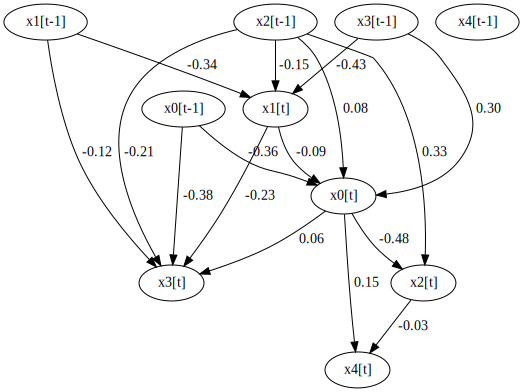

None

*run
before LinearRegression X_names= [5 6 7 8 9] , coef= [-6.57996510e-02 -1.71718869e-05  1.00701600e-02  5.28309909e-02
  4.42782371e-02]
simulation LinearRegression X_names= [5 6 7 8 9] , coef= [-6.51253038e-02 -2.16332577e-05  8.35022236e-03  5.22278300e-02
  2.90392560e-02]
before_after LinearRegression X_names= [5 6 7 8 9] , coef= [-6.60386943e-02 -5.49291633e-05  9.93055025e-03  5.28691403e-02
  4.41959808e-02]
*run shuffle
before LinearRegression X_names= [5 6 7 8 9] , coef= [-6.57996510e-02 -1.71718869e-05  1.00701600e-02  5.28309909e-02
  4.42782371e-02]
simulation LinearRegression X_names= [5 6 7 8 9] , coef= [-6.51253038e-02 -2.16332577e-05  8.35022236e-03  5.22278300e-02
  2.90392560e-02]
before_after LinearRegression X_names= [5 6 7 8 9] , coef= [-6.60386943e-02 -5.49291633e-05  9.93055025e-03  5.28691403e-02
  4.41959808e-02]
discrete: SHD= 4.0


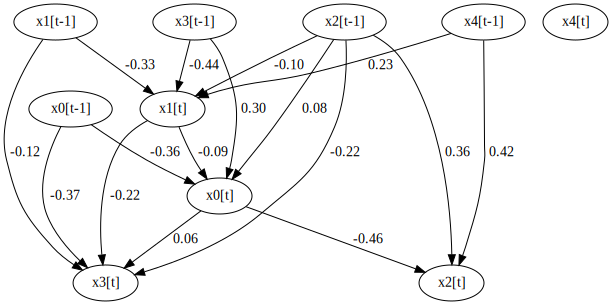

None

*run
before LogisticRegression X_names= [5 6 7 8 9] , coef= [[-0.05748788  0.05328306  0.09579663  0.03266443 -0.13578047]]
simulation LogisticRegression X_names= [5 6 7 8 9] , coef= [[-0.12363582 -0.01927473 -0.04403156  0.11488504  0.19992008]]
before_after LogisticRegression X_names= [5 6 7 8 9] , coef= [[-0.12363582 -0.01927473 -0.04403156  0.11488504  0.19992008]]
*run shuffle
before LogisticRegression X_names= [5 6 7 8 9] , coef= [[-0.08802736 -0.06319596  0.00071132  0.09710553 -0.22261718]]
simulation LogisticRegression X_names= [5 6 7 8 9] , coef= [[ 0.00487961 -0.01551147 -0.02580569 -0.04411809  0.19406108]]
before_after LogisticRegression X_names= [5 6 7 8 9] , coef= [[-0.12363582 -0.01927473 -0.04403156  0.11488504  0.19992008]]
continuous: SHD= 6.0


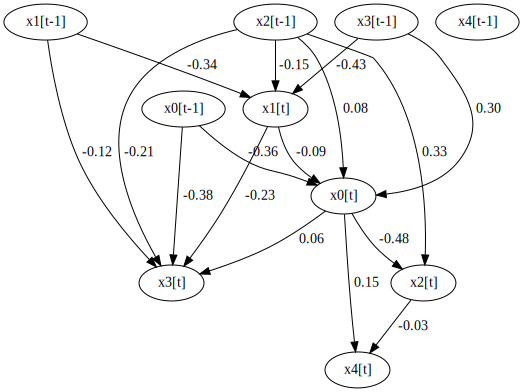

None

*run
before LinearRegression X_names= [5 6 7 8 9] , coef= [-0.09227735  0.0007165   0.01727977  0.05539528  0.04381114]
simulation LinearRegression X_names= [5 6 7 8 9] , coef= [-9.69375815e-02 -4.62695038e-05  8.23766778e-03  5.22955847e-02
  2.89575852e-02]
before_after LinearRegression X_names= [5 6 7 8 9] , coef= [-6.60386943e-02 -5.49291633e-05  9.93055025e-03  5.28691403e-02
  4.41959808e-02]
*run shuffle
before LinearRegression X_names= [5 6 7 8 9] , coef= [-0.09227735  0.0007165   0.01727977  0.05539528  0.04381114]
simulation LinearRegression X_names= [5 6 7 8 9] , coef= [-9.69375815e-02 -4.62695038e-05  8.23766778e-03  5.22955847e-02
  2.89575852e-02]
before_after LinearRegression X_names= [5 6 7 8 9] , coef= [-6.60386943e-02 -5.49291633e-05  9.93055025e-03  5.28691403e-02
  4.41959808e-02]
discrete: SHD= 5.0


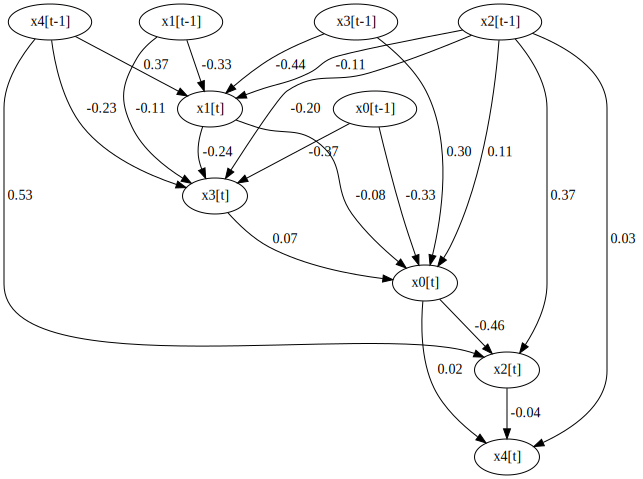

None

*run
before LogisticRegression X_names= [5 6 7 8 9] , coef= [[-0.00450505  0.06984969 -0.01267705 -0.11958195 -0.08283954]]
simulation LogisticRegression X_names= [5 6 7 8 9] , coef= [[-1.51105159  0.08972864  0.4541559   0.33255758 -0.41469257]]
before_after LogisticRegression X_names= [5 6 7 8 9] , coef= [[-0.05291119 -0.06697704  0.08398434  0.03628644 -0.22130825]]
*run shuffle
before LogisticRegression X_names= [5 6 7 8 9] , coef= [[-0.00976713  0.01249053 -0.0366762   0.02109175 -0.17044494]]
simulation LogisticRegression X_names= [5 6 7 8 9] , coef= [[-1.53143049  0.02548073  0.43691282  0.31600829 -0.66633211]]
before_after LogisticRegression X_names= [5 6 7 8 9] , coef= [[-0.05291119 -0.06697704  0.08398434  0.03628644 -0.22130825]]
continuous: SHD= 5.0


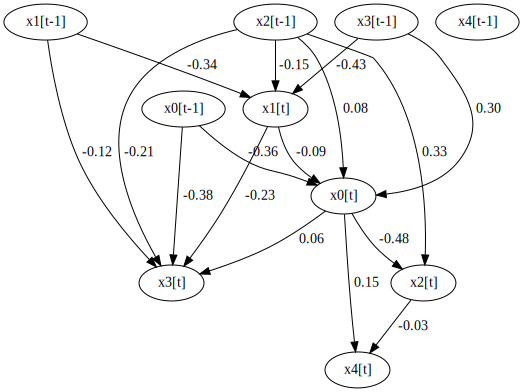

None

*run
before LinearRegression X_names= [5 6 7 8 9] , coef= [-1.22747548  0.06555055  0.1762565   0.51330474  0.38088734]
simulation LinearRegression X_names= [5 6 7 8 9] , coef= [-0.60997301  0.04406105  0.15115201  0.51795734  0.3767781 ]
before_after LinearRegression X_names= [5 6 7 8 9] , coef= [-6.60386943e-02 -5.49291633e-05  9.93055025e-03  5.28691403e-02
  4.41959808e-02]
*run shuffle
before LinearRegression X_names= [5 6 7 8 9] , coef= [-1.22747548  0.06555055  0.1762565   0.51330474  0.38088734]
simulation LinearRegression X_names= [5 6 7 8 9] , coef= [-0.60997301  0.04406105  0.15115201  0.51795734  0.3767781 ]
before_after LinearRegression X_names= [5 6 7 8 9] , coef= [-6.60386943e-02 -5.49291633e-05  9.93055025e-03  5.28691403e-02
  4.41959808e-02]
discrete: SHD= 6.0


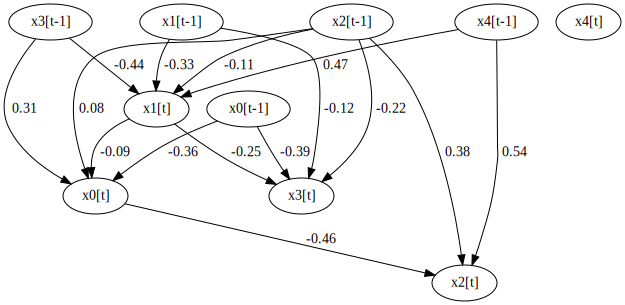

None

*run
before LogisticRegression X_names= [5 6 7 8 9] , coef= [[-0.04285725 -0.03261772  0.04728633  0.09333186 -0.02381276]]
simulation LogisticRegression X_names= [5 6 7 8 9] , coef= [[-0.47488956  0.04644963  0.0702619   0.39649667  0.04141599]]
before_after LogisticRegression X_names= [5 6 7 8 9] , coef= [[-0.10203499  0.01148577 -0.01473978  0.08637971  0.04551257]]
*run shuffle
before LogisticRegression X_names= [5 6 7 8 9] , coef= [[-0.00525653  0.14747233  0.02260384  0.03726487 -0.0902316 ]]
simulation LogisticRegression X_names= [5 6 7 8 9] , coef= [[-0.45631977  0.04817308  0.06756091  0.39677664 -0.02733694]]
before_after LogisticRegression X_names= [5 6 7 8 9] , coef= [[-0.10203499  0.01148577 -0.01473978  0.08637971  0.04551257]]


In [3]:
# 実験間で共通のデータ

# 誤差項: 誤差項は倍の長さが必要になるので注意。changing_exogでも。
sample_size = 1000
error = []
for ratio in ratio_list:
    a = np.sqrt(3 * ratio)
    error.append(np.random.uniform(-a, a, size=sample_size*2))
error = np.array(error).T

# 機械学習モデル
#param_grid = {"n_estimators": [1, 2, 3]}
param_grid = {"n_estimators": [50, 100, 200]}
ml_models_c = {"lr": LinearRegression(), "rf": GridSearchCV(RandomForestRegressor(), param_grid)}
ml_models_d = {"lr": LogisticRegression(), "rf": GridSearchCV(RandomForestClassifier(), param_grid)}

# 離散変数
is_discrete = [False for _ in range(causal_graph_true.shape[1])]
is_discrete[sink_index] = True

# 評価関数
eval_funcs_c = {"mse": mean_squared_error}
eval_funcs_d = {"precision": precision_score, "recall": recall_score}

# 実験の設定
test_info = []

# 各実験の設定作成

# 実験1: エッジ削除 (x3->x2を削除)
causal_graph = causal_graph_true.copy()
causal_graph[0, 2, 3] = 0

test_info.append({
    "name": "remove",
    "modified_causal_graph": causal_graph,
})

# 実験2: エッジ追加 (x0[t-1]->x2を追加)
causal_graph = causal_graph_true.copy()
causal_graph[1, 2, 0] = 1

test_info.append({
    "name": "add",
    "modified_causal_graph": causal_graph,
})

# 実験3: エッジ係数値の変更 (x0->x4を10倍に設定)
causal_graph = causal_graph_true.copy()
causal_graph[0, 4, 0] *= 10

test_info.append({
    "name": "modify",
    "modified_causal_graph": causal_graph,
})

# 実験を行っていく
results = {}
for info in test_info:
    # sinkが連続
    cdt = CausalDigitalTwin(causal_graph_true, error, data_gen_time_series, sink_index, cd_algo_name="VARLiNGAM")
    
    # 因果探索結果(連続)
    shd = SHD(to_dag(info["modified_causal_graph"]).astype(bool).astype(int), to_dag(cdt._est_adj).astype(bool).astype(int), double_for_anticausal=False)
    print("continuous: SHD=", shd)
    display(draw_graph(cdt._est_adj))
    
    print("*run")
    result = cdt.run(ml_models_c, eval_funcs_c, causal_graph=info["modified_causal_graph"])
    
    # sinkが連続&シャッフル
    print("*run shuffle")
    result_shuffle = cdt.run(ml_models_c, eval_funcs_c, causal_graph=info["modified_causal_graph"], shuffle_residual=True)
    
    # sinkが離散
    def data_gen_time_series_d(causal_graph, error):
        X_d, error = data_gen_time_series(causal_graph_true, error, discrete_index=sink_index)
        return X_d, error
    cdt = CausalDigitalTwin(causal_graph_true, error, data_gen_time_series_d, sink_index, is_discrete=is_discrete, cd_algo_name="VARLiNGAM")

    # 因果探索結果(連続)
    shd = SHD(to_dag(info["modified_causal_graph"]).astype(bool).astype(int), to_dag(cdt._est_adj).astype(bool).astype(int), double_for_anticausal=False)
    print("discrete: SHD=", shd)
    display(draw_graph(cdt._est_adj))
    
    print("*run")
    result_d = cdt.run(ml_models_d, eval_funcs_d, causal_graph=info["modified_causal_graph"])

    # sinkが離散&シャッフル
    print("*run shuffle")
    result_d_shuffle = cdt.run(ml_models_d, eval_funcs_d, causal_graph=info["modified_causal_graph"], shuffle_residual=True)

    results[info["name"]] = {
        "continuous": result,
        "continuous_shuffle": result_shuffle,
        "discrete": result_d,
        "discrete_shuffle": result_d_shuffle,
    }

## 実験結果

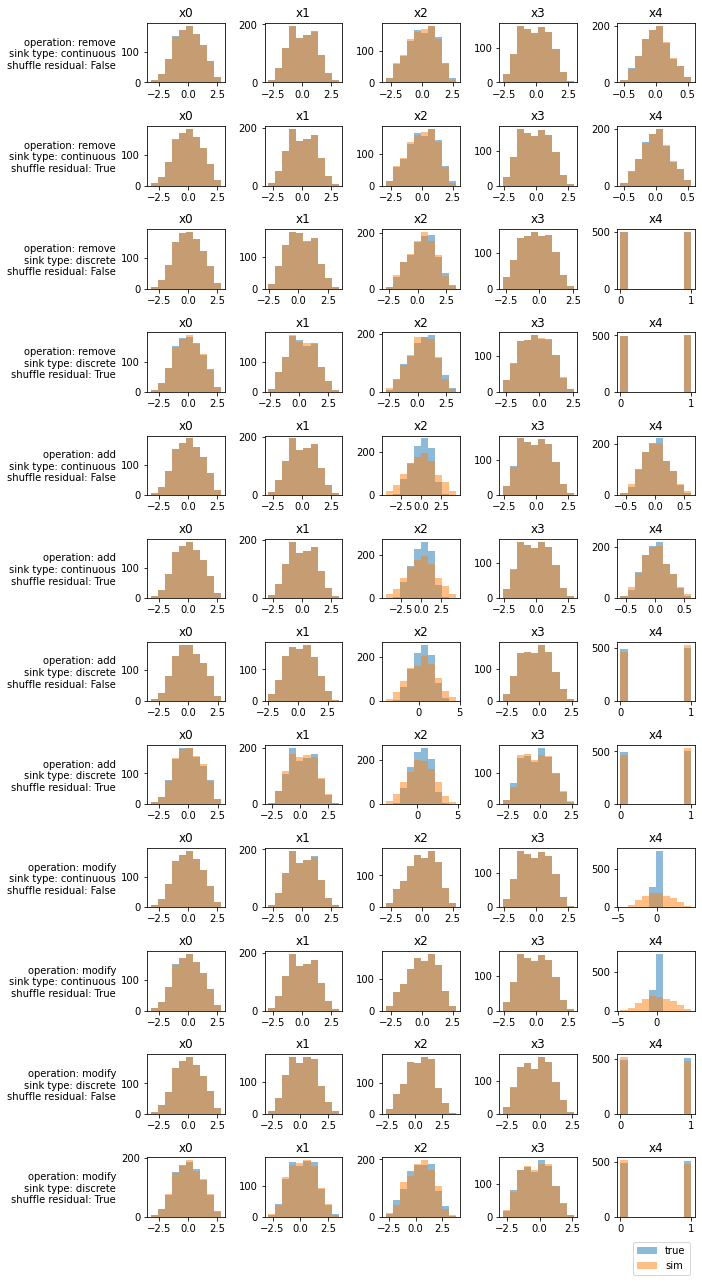

In [4]:
# 環境変化前の真のデータと環境変化後のシミュレーションデータ
n_features = len(causal_graph_true[0])
n_patterns = len(results) * len(results["add"])
draw_hist(n_features, n_patterns, results)

In [5]:
# シンク変数に対する機械学習モデルの精度
table_c, table_d = make_tables(results)
display(table_c.style.hide(axis="index"))
display(table_d.style.hide(axis="index"))

operation,model,shuffle error,MSE(true),MSE(sim),MSE(est)
remove,LinearRegression,False,0.039,0.039,0.039
remove,RandomForestRegressor,False,0.006,0.006,0.008
remove,LinearRegression,True,0.039,0.052,0.039
remove,RandomForestRegressor,True,0.006,0.069,0.008
add,LinearRegression,False,0.039,0.040,0.040
add,RandomForestRegressor,False,0.006,0.007,0.036
add,LinearRegression,True,0.039,0.066,0.040
add,RandomForestRegressor,True,0.006,0.081,0.036
modify,LinearRegression,False,2.389,2.426,3.219
modify,RandomForestRegressor,False,0.401,0.403,3.102


operation,model,shuffle error,Precision(true),Precision(sim),Precision(est),Recall(true),Recall(sim),Recall(est)
remove,LogisticRegression,False,0.526,0.502,0.488,0.509,0.511,0.485
remove,RandomForestClassifier,False,1.000,0.490,0.493,1.000,0.493,0.515
remove,LogisticRegression,True,0.555,0.492,0.526,0.671,0.482,0.520
remove,RandomForestClassifier,True,1.000,0.536,0.529,1.000,0.516,0.503
add,LogisticRegression,False,0.528,0.495,0.501,0.524,0.538,0.579
add,RandomForestClassifier,False,1.000,0.518,0.492,1.000,0.558,0.536
add,LogisticRegression,True,0.543,0.487,0.474,0.173,0.564,0.556
add,RandomForestClassifier,True,1.000,0.493,0.476,1.000,0.558,0.503
modify,LogisticRegression,False,0.518,0.501,0.525,0.542,0.448,0.653
modify,RandomForestClassifier,False,1.000,0.544,0.509,1.000,0.522,0.530


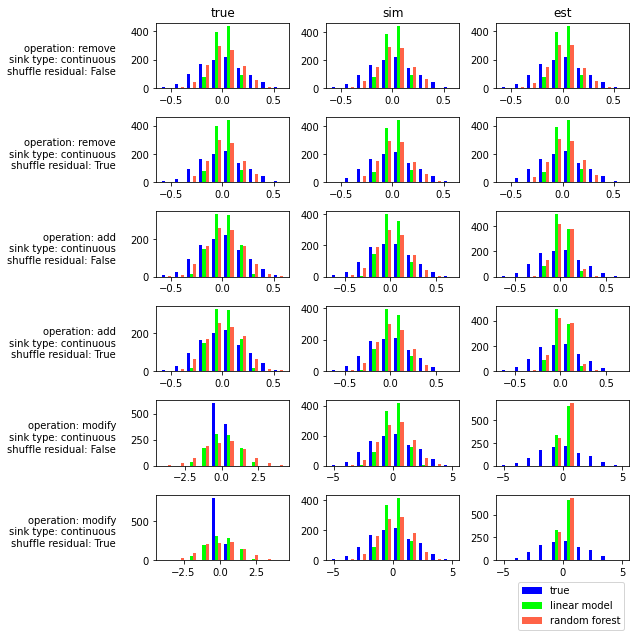

Converting input from bool to <class 'numpy.uint8'> for compatibility.


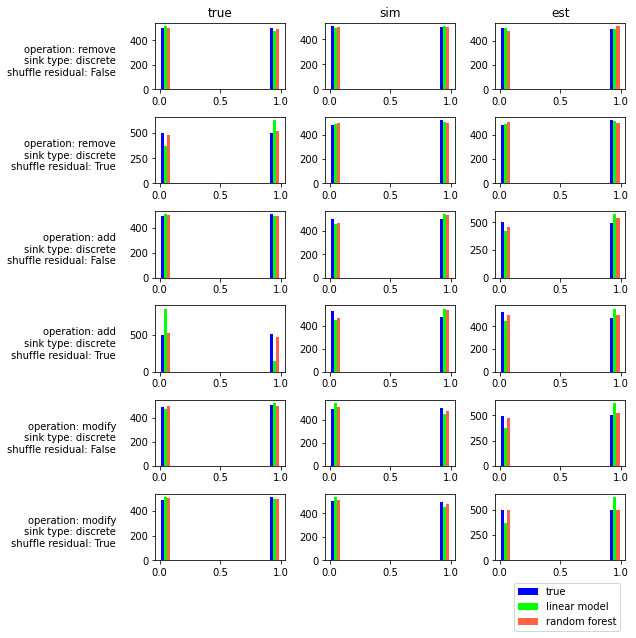

In [6]:
n_patterns = len(results) * len(results["add"])
draw_pred_hist(n_patterns, results, sink_index)